In [1]:
import tensorflow as tf
import keras
from keras import layers
from random import randint
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

d:\Projekty\misc\cat-flap\.venv\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
IMG_SIZE = (224, 224)
batch_size = 32
validation_split = 0.2

In [3]:
seed = randint(0, 2**32 - 1)

In [4]:
dataDir = 'datasets/processed_binary'
baseWeightsSavePath = 'weights/best_binary.keras'
baseFinetunedSavePath = 'weights/best_finetuned_binary.keras'

In [5]:
tf.config.list_physical_devices("GPU")

[]

In [6]:
base_model = keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,), include_top=False, weights="imagenet"
)
# Freeze the base model initially
base_model.trainable = False


In [7]:
train_ds = keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    label_mode="binary",
)

val_ds = keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    label_mode="binary",
)

# Create data augmentation layer
data_augmentation = keras.Sequential(
    [
        layers.RandomRotation(0.15, fill_mode="nearest"),
        layers.RandomTranslation(0.2, 0.2, fill_mode="nearest"),
        layers.RandomZoom(0.1, fill_mode="nearest"),
        layers.RandomFlip("horizontal"),
        layers.RandomBrightness(0.3),
    ]
)


# Apply augmentation only to training dataset
def augment_images(image, label):
    return data_augmentation(image, training=True), label


# Normalize pixel values to [0,1]
normalization_layer = layers.Rescaling(1.0 / 255)

# Process training dataset (with augmentation)
train_ds = (
    train_ds.map(lambda x, y: (normalization_layer(x), y))
    .map(augment_images, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Process validation dataset (without augmentation)
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)).prefetch(
    buffer_size=tf.data.AUTOTUNE
)


Found 1766 files belonging to 2 classes.
Using 1413 files for training.


Found 1766 files belonging to 2 classes.
Using 353 files for validation.


In [8]:
checkpoint_callback_base = keras.callbacks.ModelCheckpoint(
    filepath=baseWeightsSavePath,
    monitor="val_accuracy",  # You can use 'val_loss' for less overfitting
    save_best_only=True,  # Critical: only save if validation improves
    save_weights_only=False,  # Save entire model (architecture + weights)
    mode="max",  # 'max' for accuracy, 'min' for loss
    verbose=1,
)

checkpoint_callback_finetune = keras.callbacks.ModelCheckpoint(
    filepath=baseFinetunedSavePath,
    monitor="val_accuracy",  # You can use 'val_loss' for less overfitting
    save_best_only=True,  # Critical: only save if validation improves
    save_weights_only=False,  # Save entire model (architecture + weights)
    mode="max",  # 'max' for accuracy, 'min' for loss
    verbose=1,
)

# Callback 2: Early stopping to prevent overfitting
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,  # Stop after 5 epochs without improvement
    restore_best_weights=True,  # Keep the best weights when stopping
)

# Callback 3: Reduce learning rate when plateauing
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,  # Reduce learning rate by half
    patience=3,  # Wait 3 epochs
    min_lr=1e-7,  # Minimum learning rate
)

callbacks = [early_stop, reduce_lr]

In [9]:
model = keras.Sequential(
    [
        base_model,
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(128, activation="relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)

In [ ]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)


In [11]:
history = model.fit(
    train_ds,
    epochs=15,  # Initial phase
    validation_data=val_ds,
    callbacks=[checkpoint_callback_base, *callbacks],
)


Epoch 1/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - accuracy: 0.5095 - loss: 0.8163
Epoch 1: val_accuracy improved from None to 0.57507, saving model to weights/best_binary.keras

Epoch 1: finished saving model to weights/best_binary.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 674ms/step - accuracy: 0.5244 - loss: 0.7640 - val_accuracy: 0.5751 - val_loss: 0.6688 - learning_rate: 0.0010
Epoch 2/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.4999 - loss: 0.7169
Epoch 2: val_accuracy improved from 0.57507 to 0.64873, saving model to weights/best_binary.keras

Epoch 2: finished saving model to weights/best_binary.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 661ms/step - accuracy: 0.5209 - loss: 0.7044 - val_accuracy: 0.6487 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 3/15
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.5342 - loss: 0.6955
Epoch 3: val_accuracy did not improve from 0.64873
45/45 ━━━━━━━━━━━━━━━━━━━━ 31s 661ms/step - accuracy: 0.5513 - loss: 0.6896 - val_accuracy: 

In [13]:
model.load_weights(baseWeightsSavePath)

In [12]:
validation_loss, validation_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {validation_accuracy:.2%}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 459ms/step - accuracy: 0.6516 - loss: 0.6252
Validation Accuracy: 65.16%


In [14]:
base_model.trainable = True

fine_tune = 40
for i, layer in enumerate(base_model.layers):
    layer.trainable = i >= len(base_model.layers) - fine_tune

# Recompile with lower learning rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),  # Much smaller LR # pyright: ignore[reportArgumentType]
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

print(f"\nPhase 2: Fine-tuning last {fine_tune} layers...")
history_fine = model.fit(
    train_ds,
    initial_epoch=history.epoch[-1],
    epochs=20,
    validation_data=val_ds,
    callbacks=[checkpoint_callback_finetune, *callbacks],
)



Phase 2: Fine-tuning last 40 layers...
Epoch 15/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.5776 - loss: 0.6851
Epoch 15: val_accuracy improved from None to 0.65722, saving model to weights/best_finetuned_binary.keras

Epoch 15: finished saving model to weights/best_finetuned_binary.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 52s 914ms/step - accuracy: 0.5761 - loss: 0.6839 - val_accuracy: 0.6572 - val_loss: 0.6280 - learning_rate: 1.0000e-05
Epoch 16/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.5619 - loss: 0.6879
Epoch 16: val_accuracy did not improve from 0.65722
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 876ms/step - accuracy: 0.5669 - loss: 0.6850 - val_accuracy: 0.6544 - val_loss: 0.6265 - learning_rate: 1.0000e-05
Epoch 17/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.5357 - loss: 0.6925
Epoch 17: val_accuracy did not improve from 0.65722
45/45 ━━━━━━━━━━━━━━━━━━━━ 43s 916ms/step - accuracy: 0.5499 - loss: 0.6899 - val_accuracy: 0.6459 - val_loss: 0.6269 - learn

In [15]:
model.load_weights(baseFinetunedSavePath)


In [16]:
labels = keras.utils.image_dataset_from_directory(
    dataDir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    shuffle=False,
    label_mode="binary",
).class_names # pyright: ignore[reportAttributeAccessIssue]


Found 1766 files belonging to 2 classes.
Using 353 files for validation.


In [17]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in val_ds:
    y_true.append(label_batch.numpy())

    pred = model.predict(image_batch)

    indices = np.argmax(pred, axis=-1)

    res = np.zeros_like(pred)

    np.put_along_axis(res, indices[:, None], 1, axis=-1)

    y_pred.append(res)

# convert the true and predicted labels into tensors
correct_labels = np.concat(y_true, axis=0)
predicted_labels = np.concat(y_pred, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 517ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


In [18]:
predicted_labels

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [19]:
correct_labels

array([[0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],

              precision    recall  f1-score   support

       close       0.00      0.00      0.00       148
        open       0.58      1.00      0.73       205

    accuracy                           0.58       353
   macro avg       0.29      0.50      0.37       353
weighted avg       0.34      0.58      0.43       353



d:\Projekty\misc\cat-flap\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projekty\misc\cat-flap\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projekty\misc\cat-flap\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


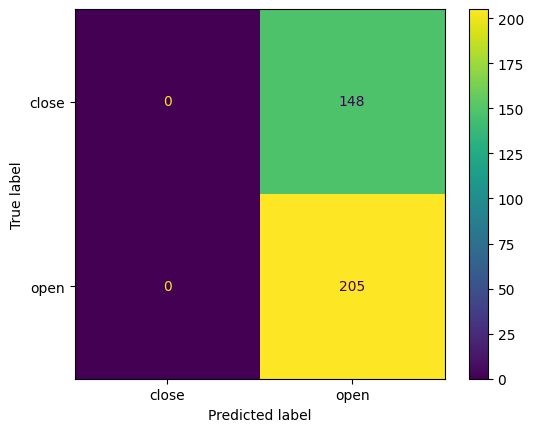

In [20]:
print(classification_report(correct_labels, predicted_labels,target_names=labels))

cmat = confusion_matrix(
    correct_labels,
    predicted_labels,
    labels=[0, 1],
)

ConfusionMatrixDisplay(
    confusion_matrix=cmat,
    display_labels=labels
).plot()
